
=== Cluster Summary (Numeric Features) ===
         Thrill   Family  Water  Shows  Food  Shopping  Relaxation  Wait Time
Cluster                                                                      
0          5.60     5.10   6.20    2.9  3.10      1.70        3.40      21.00
1          6.86     2.57   5.64    4.5  3.93      2.71        1.79      36.07
2          4.70     3.60   1.90    4.7  6.00      4.20        2.90      22.50
3          1.50     5.80   2.50    6.1  4.90      3.00        4.20      19.50

=== Cluster Summary (Categorical Profiles) ===
        Age Group Duration             Walking Break Preference
Cluster                                                        
0           18–30  4–6 hrs    Moderate walking         Flexible
1           18–30  All day  Don’t mind walking         Flexible
2           18–30  2–4 hrs  Don’t mind walking         Flexible
3           31–45  2–4 hrs    Moderate walking    After 2 hours


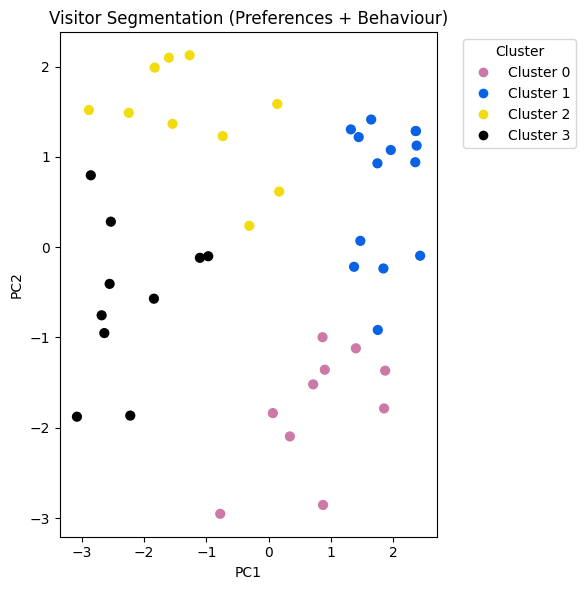

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


file_path = "Survey Responses-2.xlsx"   
df = pd.read_excel(file_path)


preference_cols = ["Thrill", " Family", "Water", "Shows", "Food", "Shopping", "Relaxation"]
demo_behaviour_cols = ["Age Group", "Duration", "Wait Time", "Walking", "Break Preference"]

selected_features = preference_cols + demo_behaviour_cols

SCALE_MAX = 7
df[preference_cols] = (SCALE_MAX + 1) - df[preference_cols]

categorical_cols = ["Age Group", "Duration", "Walking", "Break Preference"]
numeric_cols = preference_cols + ["Wait Time"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ]
)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)  
pipeline = Pipeline(steps=[("preprocessor", preprocessor),
                           ("cluster", kmeans)])
pipeline.fit(df[selected_features])
df["Cluster"] = pipeline.predict(df[selected_features])

cluster_summary_num = df.groupby("Cluster")[numeric_cols].mean().round(2)
print("\n=== Cluster Summary (Numeric Features) ===")
print(cluster_summary_num)

cluster_summary_cat = df.groupby("Cluster")[categorical_cols].agg(lambda x: x.mode()[0])
print("\n=== Cluster Summary (Categorical Profiles) ===")
print(cluster_summary_cat)

X_processed = preprocessor.fit_transform(df[selected_features])
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_processed)

colors = ["#CC79A7", "#0762e5", "#f2dc0f", "#000000", "#d6f5ff", "#9b0000"] 

plt.figure(figsize=(6,6))
scatter = plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=[colors[i] for i in df["Cluster"]], 
    s=40
)

plt.title("Visitor Segmentation (Preferences + Behaviour)")
plt.xlabel("PC1")
plt.ylabel("PC2")

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label=f"Cluster {i}",
           markerfacecolor=colors[i], markersize=8)
    for i in sorted(df["Cluster"].unique())
]

plt.legend(handles=legend_elements,
           title="Cluster",
           bbox_to_anchor=(1.05, 1),
           loc="upper left",
           frameon=True)

plt.tight_layout()
plt.show()

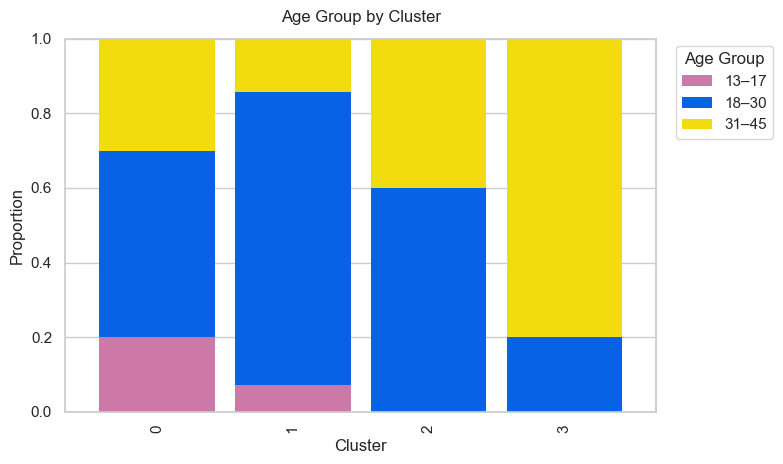

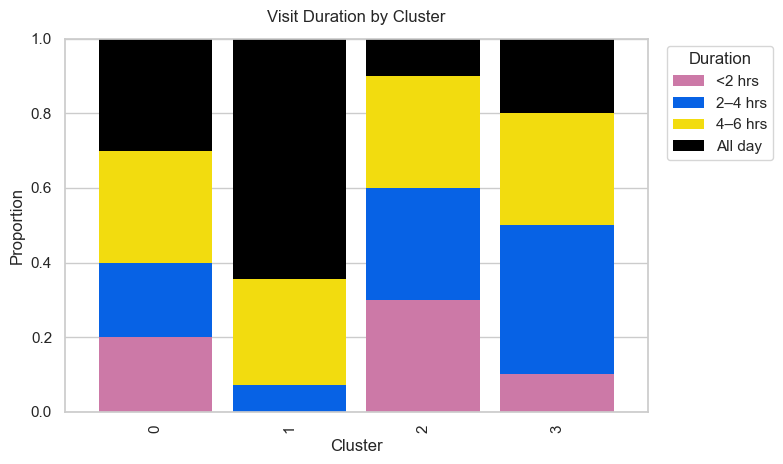

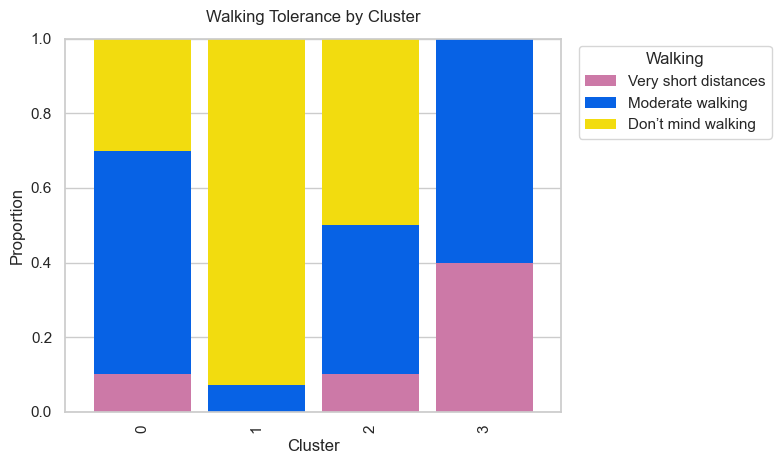

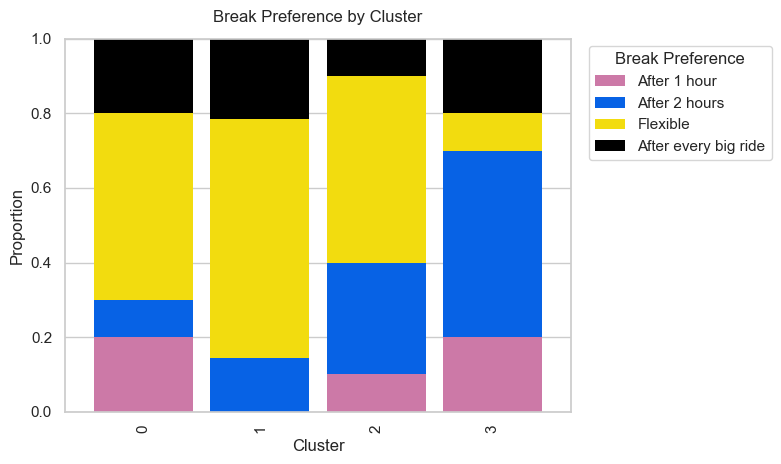

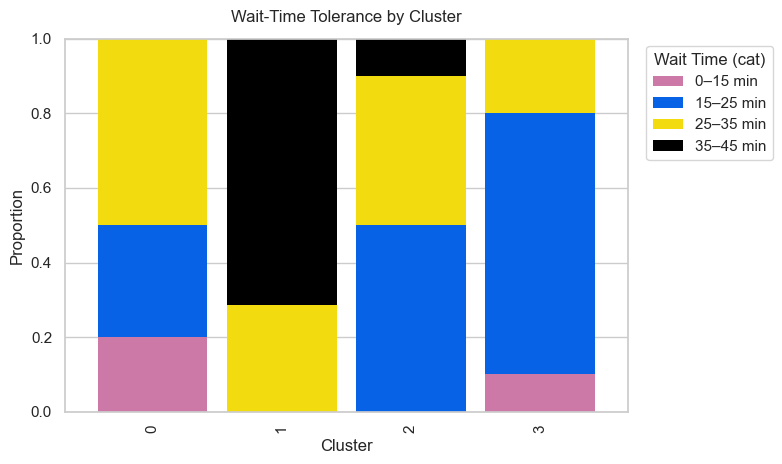

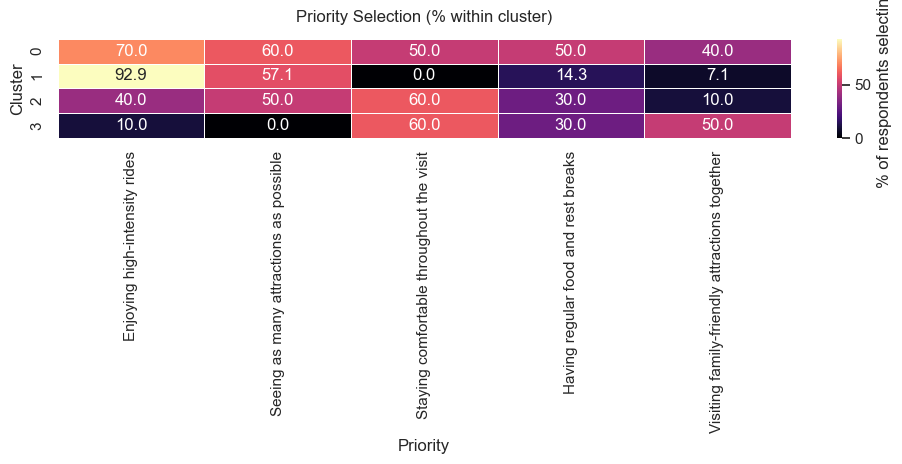

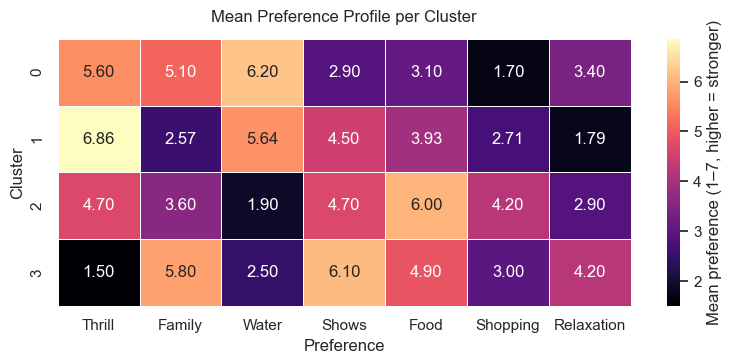

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(context="notebook", style="whitegrid", font_scale=1.0)
FIG_DIR = "figs"
os.makedirs(FIG_DIR, exist_ok=True)

colors =  ["#CC79A7", "#0762e5", "#f2dc0f", "#000000", "#d6f5ff"] 


def stacked_bar_by_cluster(df, col, order=None, title=None, fname=None):

    if col not in df.columns:
        print(f"[skip] column not found: {col}")
        return

    ct = pd.crosstab(df["Cluster"], df[col])
    if order is not None:
        ct = ct.reindex(columns=[c for c in order if c in ct.columns])
    props = ct.div(ct.sum(axis=1), axis=0)
    
    ax = props.plot(kind="bar", stacked=True, figsize=(8, 4.8), edgecolor="none", width=0.85, color=colors)
    ax.set_xlabel("Cluster")
    ax.set_ylabel("Proportion")
    ax.set_ylim(0, 1)
    if title:
        ax.set_title(title, pad=12)
    ax.legend(title=col, bbox_to_anchor=(1.02, 1), loc="upper left", frameon=True)
    plt.tight_layout()
    if fname:
        plt.savefig(os.path.join(FIG_DIR, fname), dpi=300, bbox_inches="tight")
    plt.show()

age_order      = ["13–17", "18–30", "31–45", "46–60", "60+"]
duration_order = ["<2 hrs", "2–4 hrs", "4–6 hrs", "All day"]
walking_order  = ["Very short distances", "Moderate walking", "Don’t mind walking"]
break_order    = ["After 1 hour", "After 2 hours", "Flexible", "After every big ride"]


df["Wait Time"] = pd.to_numeric(df["Wait Time"], errors="coerce")

wait_bins   = [0, 15, 25, 35, 45] 
wait_labels = ["0–15 min", "15–25 min", "25–35 min", "35–45 min"]

df["Wait Time (cat)"] = pd.cut(df["Wait Time"], 
                               bins=wait_bins, 
                               labels=wait_labels, 
                               include_lowest=True, 
                               right=False)

df["Wait Time (cat)"] = pd.Categorical(df["Wait Time (cat)"], 
                                       categories=wait_labels, 
                                       ordered=True)


stacked_bar_by_cluster(df, "Age Group",      order=age_order,
                       title="Age Group by Cluster", fname="demographics_age_by_cluster.png")

stacked_bar_by_cluster(df, "Duration",       order=duration_order,
                       title="Visit Duration by Cluster", fname="demographics_duration_by_cluster.png")

stacked_bar_by_cluster(df, "Walking",        order=walking_order,
                       title="Walking Tolerance by Cluster", fname="behaviour_walking_by_cluster.png")

stacked_bar_by_cluster(df, "Break Preference", order=break_order,
                       title="Break Preference by Cluster", fname="behaviour_breaks_by_cluster.png")

stacked_bar_by_cluster(
    df,
    "Wait Time (cat)",
    order=wait_labels,
    title="Wait-Time Tolerance by Cluster",
    fname="behaviour_wait_time_by_cluster.png"
)


def build_priority_matrix(df, col="Priorities"):
    """
    Convert multi-select priorities column into a wide binary matrix.
    Expects comma-separated phrases. Ignores NaNs.
    """
    if col not in df.columns:
        print(f"[skip] column not found: {col}")
        return None
    
    all_items = set()
    parsed = []
    for v in df[col].fillna(""):
        items = [x.strip() for x in str(v).split(",") if str(x).strip()]
        parsed.append(items)
        all_items.update(items)
    all_items = sorted(all_items)
    
    mat = np.zeros((len(df), len(all_items)), dtype=int)
    for i, items in enumerate(parsed):
        for it in items:
            if it in all_items:
                mat[i, all_items.index(it)] = 1
    
    M = pd.DataFrame(mat, columns=all_items, index=df.index)
    return M

prior_mat = build_priority_matrix(df, col="Priorities")

if prior_mat is not None:
    pm = pd.concat([df["Cluster"], prior_mat], axis=1).groupby("Cluster").mean() * 100.0

    topN = 8
    overall = prior_mat.mean().sort_values(ascending=False)
    cols_to_show = list(overall.head(topN).index)
    
    plt.figure(figsize=(10, 4.8))
    sns.heatmap(pm[cols_to_show].round(1), annot=True, fmt=".1f", cmap="magma",
                cbar_kws={"label": "% of respondents selecting"},
                linewidths=0.5, linecolor="white")
    plt.title("Priority Selection (% within cluster)", pad=12)
    plt.xlabel("Priority")
    plt.ylabel("Cluster")
    plt.tight_layout()
    plt.savefig(os.path.join(FIG_DIR, "priorities_heatmap_topN.png"), dpi=300, bbox_inches="tight")
    plt.show()

pref_targets = ["Thrill","Family","Water","Shows","Food","Shopping","Relaxation"]
pref_map = {}
for name in pref_targets:
    match = [c for c in df.columns if c.strip().lower() == name.lower()]
    if match:
        pref_map[name] = match[0]
pref_cols_clean = [pref_map[k] for k in pref_targets if k in pref_map]

pref_means = df.groupby("Cluster")[pref_cols_clean].mean()

pref_means.columns = [c.strip().title() for c in pref_means.columns]

plt.figure(figsize=(8, 3.8))
sns.heatmap(pref_means, annot=True, fmt=".2f", cmap="magma", linewidths=0.5, linecolor="white",
            cbar_kws={"label":"Mean preference (1–7, higher = stronger)"})
plt.title("Mean Preference Profile per Cluster", pad=12)
plt.xlabel("Preference")
plt.ylabel("Cluster")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "preferences_mean_heatmap.png"), dpi=300, bbox_inches="tight")
plt.show()

# Ratings (Likert Scale)

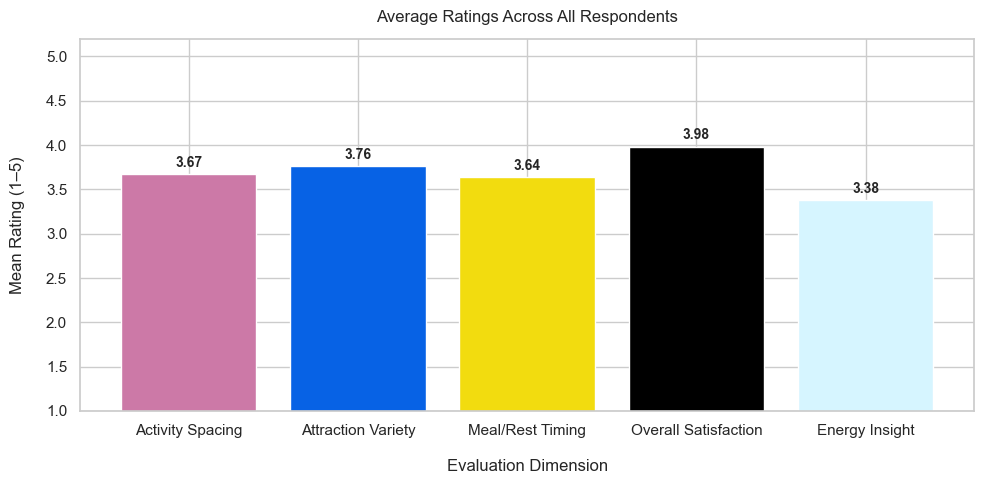

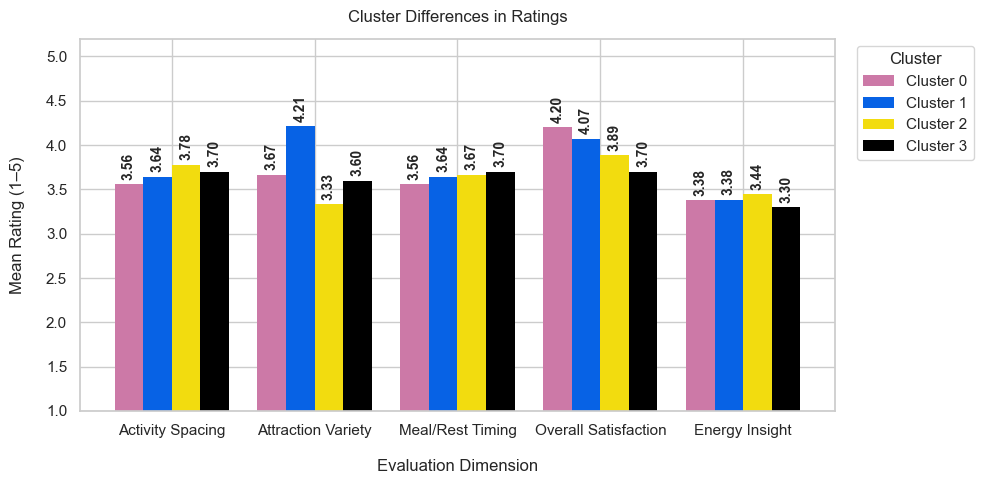

In [3]:
likert_cols = [
    "Activity Spacing Rating (1–5)",
    "Attraction Variety Rating (1–5)",
    "Meal/Rest Timing Rating (1–5)",
    "Overall Satisfaction Rating (1–5)",
    "Energy Insight"
]

mean_ratings = df[likert_cols].mean().round(2)

colors = ["#CC79A7", "#0762e5", "#f2dc0f", "#000000", "#d6f5ff"] 

short_labels = [
    "Activity Spacing",
    "Attraction Variety",
    "Meal/Rest Timing",
    "Overall Satisfaction",
    "Energy Insight"
]

plt.figure(figsize=(10,5))
bars = plt.bar(short_labels, mean_ratings.values, color=colors[:len(mean_ratings)])

for i, val in enumerate(mean_ratings.values):
    plt.text(i, val + 0.05, f"{val:.2f}", ha="center", va="bottom", fontsize=10, fontweight="bold")

plt.title("Average Ratings Across All Respondents", pad=12)
plt.ylabel("Mean Rating (1–5)", labelpad=15)
plt.xlabel("Evaluation Dimension", labelpad=15)   

plt.ylim(1, 5.2)
plt.tight_layout()
plt.show()

cluster_likert_means = df.groupby("Cluster")[likert_cols].mean().reset_index()
cluster_likert_means = cluster_likert_means.melt(id_vars="Cluster", 
                                                 value_vars=likert_cols,
                                                 var_name="Rating Item",
                                                 value_name="Mean Score")

cluster_means = df.groupby("Cluster")[likert_cols].mean()

x = np.arange(len(likert_cols))                     
n_clusters = cluster_means.shape[0]                 
bar_width = 0.2  
offsets = np.linspace(-bar_width*(n_clusters-1)/2, 
                      bar_width*(n_clusters-1)/2, 
                      n_clusters)

plt.figure(figsize=(10,5))

for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    plt.bar(x + offsets[i], row.values, 
            width=bar_width, 
            label=f"Cluster {cluster}", 
            color=colors[i % len(colors)], 
            edgecolor="none")

for i, (cluster, row) in enumerate(cluster_means.iterrows()):
    for j, val in enumerate(row.values):
        plt.text(x[j] + offsets[i], val + 0.05, f"{val:.2f}", 
                 ha="center", va="bottom", fontsize=10, fontweight="bold", rotation=90)

plt.title("Cluster Differences in Ratings", pad=12)
plt.ylabel("Mean Rating (1–5)", labelpad=15)
plt.xlabel("Evaluation Dimension", labelpad=15)
plt.xticks(x, ["Activity Spacing", "Attraction Variety", "Meal/Rest Timing", 
               "Overall Satisfaction", "Energy Insight"], )
plt.ylim(1, 5.2)
plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

# Feedback (Text Based)

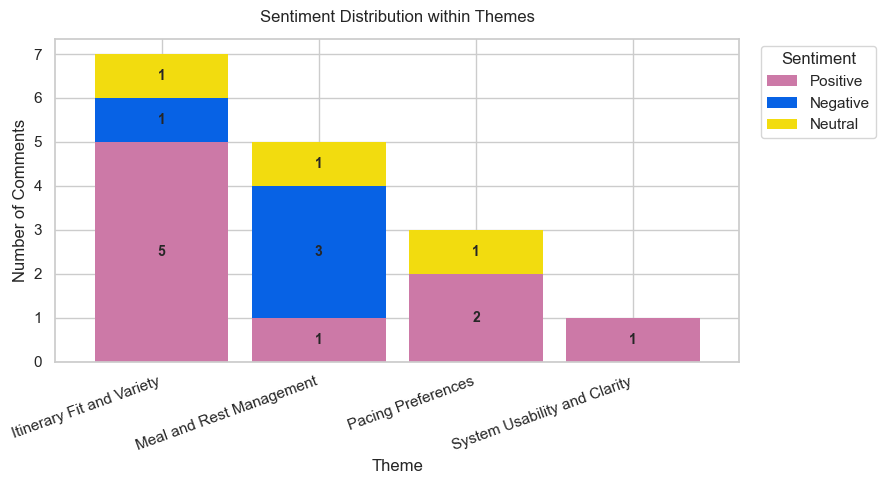

In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

CSV_PATH = "freetext_sentiment.csv"   
FIG_DIR  = "figs_feedback"
os.makedirs(FIG_DIR, exist_ok=True)

sns.set(context="notebook", style="whitegrid", font_scale=1.0)
colors = ["#CC79A7", "#0762e5", "#f2dc0f", "#000000"] 

THEME_ORDER = [
    "Itinerary Composition (Variety/Flow)",
    "Meal/Rest & Relaxation",
    "Thrill Ride Interest",
    "System/Interface Experience"
]
SENTIMENT_ORDER = ["Positive", "Negative", "Neutral"] 

df = pd.read_csv(CSV_PATH)

if df.columns.duplicated().any():
    new_cols = []
    seen = {}
    for c in df.columns:
        if c not in seen:
            seen[c] = 0
            new_cols.append(c)
        else:
            seen[c] += 1
            new_cols.append(f"{c}.{seen[c]}")
    df.columns = new_cols

def find_col(df, target):
    candidates = [c for c in df.columns if c.strip().lower() == target.lower()]
    if not candidates:
        raise KeyError(f"Required column '{target}' not found in CSV. Got: {list(df.columns)}")
    return candidates[0]

feedback_col  = find_col(df, "Feedback Comments")
theme_col     = find_col(df, "Theme")
sentiment_col = find_col(df, "Sentiment")

df = df[[feedback_col, theme_col, sentiment_col]].copy()
df.columns = ["Feedback", "Theme", "Sentiment"]  

df = df.dropna(subset=["Feedback", "Theme", "Sentiment"])
df["Feedback"] = df["Feedback"].astype(str).str.strip()
df["Theme"]    = df["Theme"].astype(str).str.strip()
df["Sentiment"]= df["Sentiment"].astype(str).str.strip()
df = df[(df["Feedback"] != "") & (df["Theme"] != "") & (df["Sentiment"] != "")].reset_index(drop=True)

def norm_sent(x):
    xl = x.strip().lower()
    if xl in {"pos", "positive", "good", "favourable", "favorable", "pro"}:
        return "Positive"
    if xl in {"neg", "negative", "bad", "unfavourable", "unfavorable", "con"}:
        return "Negative"
    if xl in {"neutral", "mixed", "ambivalent"}:
        return "Neutral"
    return x.strip().title()

df["Sentiment"] = df["Sentiment"].map(norm_sent)

if THEME_ORDER:
    present_order = [t for t in THEME_ORDER if t in df["Theme"].unique().tolist()]
    if present_order:
        df["Theme"] = pd.Categorical(df["Theme"], categories=present_order, ordered=True)

sentiment_series = df["Sentiment"] 
other_sent = [s for s in sentiment_series.unique() if s not in SENTIMENT_ORDER]
plot_sentiments = SENTIMENT_ORDER + sorted([s for s in other_sent if pd.notna(s)])


ct = pd.crosstab(df["Theme"], df["Sentiment"]).reindex(columns=plot_sentiments, fill_value=0)
ax = ct.plot(kind="bar", stacked=True, figsize=(9, 5),
             color=colors,
             width=0.85, edgecolor="none")
ax.set_title("Sentiment Distribution within Themes", pad=12)
ax.set_xlabel("Theme"); ax.set_ylabel("Number of Comments")
plt.xticks(rotation=20, ha="right")
plt.legend(title="Sentiment", bbox_to_anchor=(1.02,1), loc="upper left", frameon=True)

for p in ax.patches:
    h = p.get_height()
    if h > 0:
        x = p.get_x() + p.get_width()/2
        y = p.get_y() + h/2
        ax.text(x, y, f"{int(h)}", ha="center", va="center", fontsize=10, fontweight="bold")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "sentiment_by_theme_stacked.png"), dpi=300, bbox_inches="tight")
plt.show()